In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch

try:
    import jaxtyping
except ImportError:
    %pip install jaxtyping

from typing import Optional
# Type hints are strictly optional, but personally I find that they make code more reasonable
from jaxtyping import Float
# This package allows type annotations that include the size of torch Tensors/numpy arrays
# It's not necessary, but it helps with understanding what each function does
from torch import Tensor

%matplotlib inline

# Set DTYPE and DEVICE variables for torch tensors
DTYPE = torch.float32
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
def mu(X: Float[Tensor, "N D"]) -> Float[Tensor, "N"]:
    r"""
    Computes the (very lame) zero mean function
    mu(X) = 0
    """

    return torch.zeros(*X.shape[:-1], dtype=X.dtype, device=X.device)

    # This return statement might seem like it's a pedantic way just to return the number 0 :)
    # It's not:
    # - if we want to compute a batch of GPs, the batch size of the returned zero
    #   tensor will match the batch size of X
    # - if X is a float64 tensor rather than float32, the returned zero tensor will match the correct dtype
    # - if X is on the GPU rather than the CPU, the returned zero tensor will also be on the same device

    # You don't always have to be this pedantic, but it's not a bad habit to get into

In [3]:
def k(
    X1: Float[Tensor, "M D"],
    X2: Float[Tensor, "N D"],
    ls: Float[Tensor, "1 D"],
    os: Float[Tensor, "1 1"],
) -> Float[Tensor, "M N"]:
    r"""
    Computes Matern kernel with nu=5/2 across all pg
    airs of points given by X1 and X2
    
    k(X1, X2) = os * (1 + \sqrt{5} * D + 5/3 * (D**2)) * exp(-\sqrt(5) * D)
    D = || (X1 - X2) / ls ||_2
    https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function

    ls: lengthscale
    os: outputscale
    """

    # Compute D, D ** 2, \sqrt{5} * D
    D_sq = (X1.div(ls).unsqueeze(-2) - X2.div(ls).unsqueeze(-3)).square().sum(dim=-1)
    # ^^^ This function is using broadcasting (via the unsqueeze operation)
    #     to compute all of the pairwise distances in parallel
    #
    #     You should also get into the habit of using "negative indexes"
    #     (i.e. unsqueeze(-2) rather than unsqueeze(0))
    #     as negative indices allow you to easily write parallel code for batched operations.
    #     (Again, not important now, but a good habit to develop!)
    
    D = torch.sqrt(D_sq + 1e-20)  # The 1e-20 is for numerical stability, so we don't get any NaNs if D≈0 but is very small and negative
    
    # Compute and return kernel
    return torch.mul(
        1 + (math.sqrt(5) * D) + ((5. / 3) * D_sq),
        torch.exp(-math.sqrt(5) * D)
    ).mul(os)

In [4]:
def compute_posterior_mean_and_variance(
    X_test: Float[Tensor, "M D"],
    X: Float[Tensor, "N"],
    K_chol: Float[Tensor, "N N"],
    y: Float[Tensor, "N"],
    ls: Float[Tensor, "1 D"],
    os: Float[Tensor, "1 1"],
) -> tuple[Float[Tensor, "M"], Float[Tensor, "M M"]]:
    r"""
    Given a X_test, computes and returns the posterior moments
    - E[ f(X_test) | y ] = mu(X_test) + k(X_test, X) @ k(X, X)^{-1} @ (y - mu(X))
    - Cov[ f(X_test) | y ] = k(X_test, X_test) + k(X_test, X) @ k(X, X)^{-1} @ k(X, X_test)

    X_test:          the matrix containing test inputs we want to evaluate f() on
    X:               the matrix containing training inputs (where we have observations)
    K_chol:          the Cholesky factor of the k(X, X) kernel matrix evaluated on training inputs
                     plus observational noise
                         i.e. K_chol @ K_chol.T = (k(X, X) + sigma^2 I)
    y:               is the vector of training observations
    ls:              is the lengthscale of the kernel
    os:              is the outputscale of the kernel
    """

    # ^^^ Note:
    # You may be wondering why we are passing in K_chol,
    # rather than computing it as part of this function.
    # The reasoning will make sense once we start iteratively updating the posterior

    # Compute k(X, X)^{-1} k(X, X_test)
    # We need this term for both the posterior mean and posterior variance
    Ktest = k(X, X_test, ls, os)
    K_inv_Ktest = torch.cholesky_solve(Ktest, K_chol, upper=False)

    # ***SUPER IMPORTANT:***
    # Note that we are using `cholesky_solve` to compute k(X, X)^{-1} k(X, X_test)
    # rather than calling k(X, X).inverse() @ Ktest
    # This is highly intentional
    # 1) Never call .inverse(); it is highly unstable. Always perform matrix solves instead.
    # 2) We can use the fact that k(X, X) is positive semi-definite to speed up solves.
    #    The way we exploit this is by first applying the Cholesky decomposition to k(X, X)
    #    (which exists because it is PSD) and then using it to perform a series of triangular
    #    solves (which are fast).

    # Compute posterior mean
    posterior_mean = mu(X_test) + (K_inv_Ktest.mT @ (y - mu(X)).unsqueeze(-1)).squeeze(-1)
    # Some notes:
    # 1) .mT is the same as .T, but it works with batched tensors
    #    i.e. it transposes the last two dimensions of the tensor
    #    this helper is useful if we want to use batched GPs
    # 2) (y - mu(X)).unsqueeze(-1) turns `y - mu(X)` from a N vector into a
    #    N x 1 matrix so that we can then use the matmul function with it.
    #    ().squeeze(-1) converts the resulting matmul back into a N vector.

    # Compute posterior covariance
    posterior_covar = k(X_test, X_test, ls, os) - Ktest.mT @ K_inv_Ktest

    # Done!
    return posterior_mean, posterior_covar

In [5]:
def update_K_chol(
    K_chol: Float[Tensor, "N N"],
    X: Float[Tensor, "N D"],
    X_next: Float[Tensor, "N_next D"],
    ls: Float[Tensor, "1 D"],
    os: Float[Tensor, "1 1"],
    sigma_sq: Float[Tensor, ""],
    eps: float = 1e-4,
) -> Float[Tensor, "(N+N_next) (N+N_Next)"]:
    """
    Computes the Cholesky factor of the block matrix
    [ k(X, X) + sigma_sq * I          k(X, X_next)                      ]
    [ k(X_next, X)                    k(X_next, X_next)  + sigma_sq * I ]

    This function should efficiently use prior computation.
    Given that we already have computed K_chol @ K_chol.T = k(X, X),
    we should be able to "update" that K_chol in O(N^2) time to get the
    desired block cholesky factorization.

    eps:      Small amount of noise to add to the diagonal for stability
    """

    # TODO: this function is currently not efficient :)
    # Right now, we're just computing the block Cholesky factorization from scratch,
    #     rather than reusing K_chol for an efficient update
    # You should make this function more efficient.

    X_joint = torch.cat([X, X_next], dim=-2)
    K_joint = k(X_joint, X_joint, ls, os)

    # Add sigma_sq * I to K_joint
    #
    # *Important*: the Cholesky factorization can be a bit numerically unstable
    # If the smallest eigenvalues of K are ≈0, they can numerically appear to be slightly negative
    #     which causes the Cholesky factorization to fail
    # We can circumvent this problem by adding a small amount of diagonal noise to K_joint
    #     to bump up all of the eigenvalues
    I = torch.eye(K_joint.size(-1), dtype=K_joint.dtype, device=K_joint.device)
    K_joint = K_joint + (sigma_sq + eps) * I

    # Now we're ready to compute the Cholesky factor
    # return torch.linalg.cholesky(K_joint, upper=False)

    # Get the sub-blocks of K_joint
    N = X.size()[0]
    N_next = X_next.size()[0]
    K_11, K_12, K_22 = K_joint[0:N, 0:N], K_joint[0:N, N:], K_joint[N:, N:]

    # Cholesky factorization on the sub-blocks
    L_21 = torch.linalg.solve_triangular(K_chol, K_12, upper = False).mT
    L_22 = torch.linalg.cholesky(K_22 - L_21 @ L_21.mT, upper = False)

    # Concatenate sub-blocks of Cholesky decomposition matrix and return them in the form
    # [ K_chol      0 ]
    # [ L_21     L_22 ]
    return(torch.cat((torch.cat((K_chol, torch.zeros(N, N_next)), -1), torch.cat((L_21, L_22), -1)), -2))

In [6]:
# Fake data generating function

def observe(X: Float[Tensor, "... N 1"]) -> Float[Tensor, "N"]:
    # We will observe sin(X * 2 pi) + sin(X * 4 pi) + \eps,
    # where \eps ~ N(0, 1e-2)
    observation = X[..., 0].mul(math.pi * 2).sin() + X[..., 0].mul(math.pi * 4).sin()
    observation = observation + torch.randn_like(observation).mul(1e-2)
    return observation

In [7]:
# This function will plot the training data, posterior mean, and 95% credible interval

def plot(
    ax,
    X: Float[Tensor, "N 1"],
    y: Float[Tensor, "N"],
    X_test: Float[Tensor, "N_test 1"],
    posterior_mean: Float[Tensor, "N_test"],
    posterior_covar: Float[Tensor, "N_test N_test"],
):
    # Get everything on the cpu (if we happened to be running code on the GPU)
    # (This code will do nothing if we were already running everything on the CPU)
    X = X.cpu()
    y = y.cpu()
    X_test = X_test.cpu()
    posterior_mean = posterior_mean.cpu()
    posterior_covar = posterior_covar.cpu()
    
    # "Squeeze" out last dimension for plotting
    x: Float[Tensor, "N"] = X.squeeze(-1)
    x_test: Float[Tensor, "N_test"] = X_test.squeeze(-1)
    
    # Compute 95% credible interval ≈ +/- 2 * sqrt(posterior_var)
    posterior_var: Float[Tensor, "N_test"] = posterior_covar.diagonal(dim1=-1, dim2=-2)  # Get diagonal of covar matrix
    two_posterior_stdv = posterior_var.sqrt().mul(2.)
    ci_lower = posterior_mean - two_posterior_stdv
    ci_upper = posterior_mean + two_posterior_stdv

    # Plot posterior mean and CI
    mean_line, = ax.plot(x_test, posterior_mean, zorder=0, label="$f(\\cdot) | y$")
    ax.fill_between(x_test, ci_lower, ci_upper, zorder=-1, color=mean_line.get_color(), alpha=0.2)

    # Plot training data
    ax.scatter(x, y, marker="o", color="k", s=2, label="Train data")

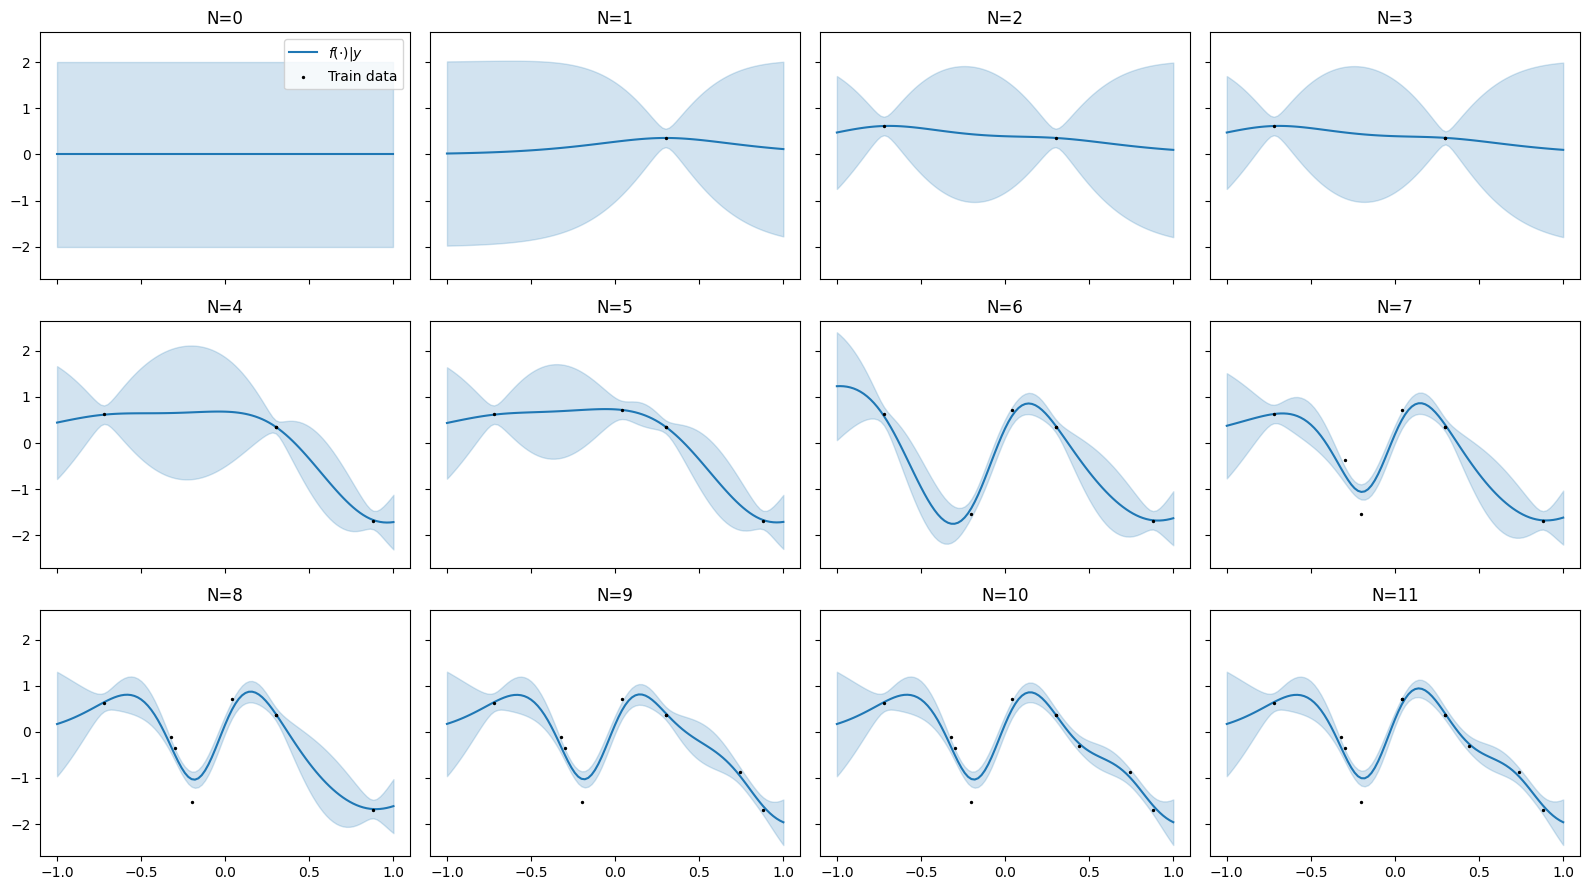

In [8]:
"""
Working version of the GP code with basic selection matrices implemented. 
TODO: Edit/refine the code for  the code to include 

# *** Iterative posterior conditioning loop ***
N_tot = 11
num_col = 4
x_min = -1.
x_max = 1.

# GP hyperparameters:
#   - ls: kernel lengthscale
#   - os: kernel outputscale
#   - sigma_sq: observational noise
ls: Float[Tensor, "1 1"] = torch.tensor(0.5, dtype=DTYPE, device=DEVICE).view(1, 1)
os: Float[Tensor, "1 1"] = torch.tensor(1., dtype=DTYPE, device=DEVICE).view(1, 1)
sigma_sq: Float[Tensor, "1 1"] = torch.tensor(1e-2, dtype=DTYPE, device=DEVICE).view(1, 1)

# Create X_test grid
N_test = 101
X_test: Float[Tensor, "N_test 1"] = torch.linspace(x_min, x_max, N_test, dtype=DTYPE, device=DEVICE)[..., None]

# Get all observations
y_test: Float[Tensor, "N_test"] = observe(X_test)

# Selection matrix 
selection: Float[Tensor, "N_test "] = torch.zeros(N_test, 0)

# Create axes where we will iteratively plot our posterior mean / credible intervals
num_row = math.ceil((N_tot + 1.) / num_col)
fig, all_axs = plt.subplots(num_row, num_col, figsize=(4 * num_col, 3 * num_row), sharex=True, sharey=True)
axs = all_axs.ravel()

# Create variables to store:
#   - K_chol:    cholesky factor of k(X, X)
#   - X:         inputs that we have observations at
#   - y:         existing observations
# They all start off as size-0 matrices, since we haven't observed anything yet
K_chol = torch.zeros(0, 0, dtype=DTYPE, device=DEVICE)
X = torch.zeros(0, 1, dtype=DTYPE, device=DEVICE)
y = torch.zeros(0, dtype=DTYPE, device=DEVICE)

# *****
# Run loop, where we
#   - Collect a new data point (random input and observation)
#   - Update our posterior based on that new data point
# *****

for N, ax in enumerate(axs):
    # If we haven't observed any data, just plot the prior mean / CI
    if N == 0:
        posterior_mean = mu(X_test)
        posterior_covar = k(X_test, X_test, ls, os)

    else:
        # Create a random input drawn uniformly from [x_min, x_max]
        # Also make an observation at that datapoint
        # X_next: Float[Tensor, "1 1"] = torch.rand(1, 1, dtype=DTYPE, device=DEVICE).mul(x_max - x_min).add(x_min)
        # y_next: Float[Tensor, "1"] = observe(X_next)
        selection = torch.cat((selection, torch.zeros(N_test, 1)), -1)
        n_next: int = torch.rand(1, dtype=DTYPE, device=DEVICE).mul(N_test).floor().int()
        X_next = X_test[n_next]
        selection[n_next, N - 1] += 1
        
        # Update the Cholesky factor, as well as the X and y variables
        K_chol = update_K_chol(K_chol, X, X_next, ls, os, sigma_sq)
        # X = torch.cat([X, X_next], dim=-2)
        # y = torch.cat([y, y_next], dim=-1)
        X = selection.mT @ X_test
        y = selection.mT @ y_test

        # Now compute posterior mean and covariance
        posterior_mean, posterior_covar = compute_posterior_mean_and_variance(X_test, X, K_chol, y, ls, os)

    plot(ax, X, y, X_test, posterior_mean, posterior_covar)
    ax.set(title=f"N={N}")

# Make things pretty
axs[0].legend(loc="best")
fig.tight_layout()

"""

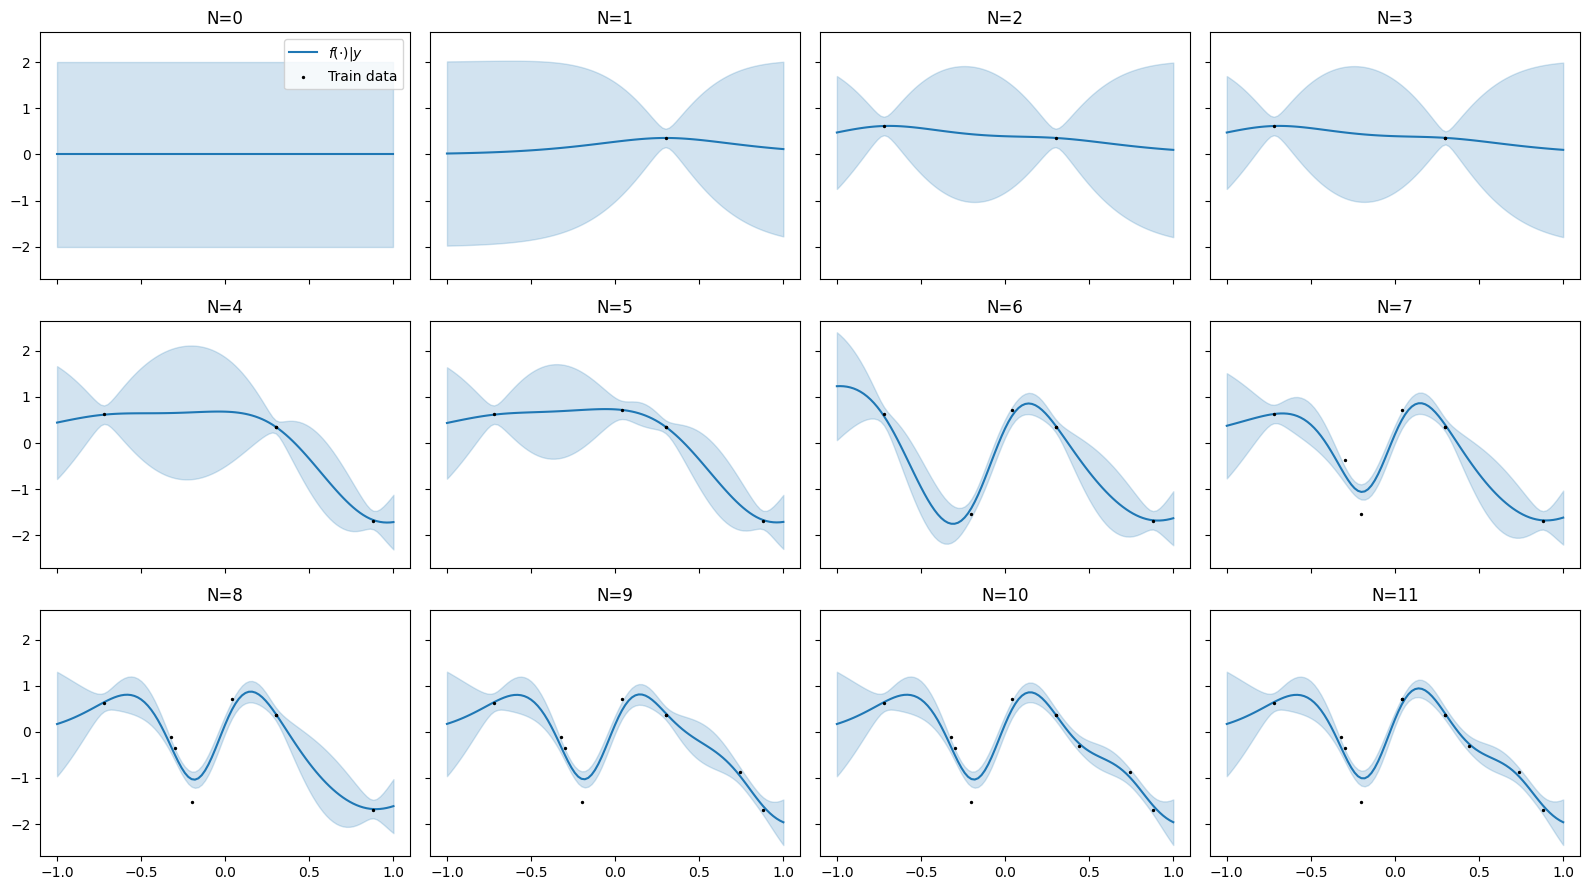

In [8]:
# *** Iterative posterior conditioning loop ***
N_tot = 11
num_col = 4
x_min = -1.
x_max = 1.

# GP hyperparameters:
#   - ls: kernel lengthscale
#   - os: kernel outputscale
#   - sigma_sq: observational noise
ls: Float[Tensor, "1 1"] = torch.tensor(0.5, dtype=DTYPE, device=DEVICE).view(1, 1)
os: Float[Tensor, "1 1"] = torch.tensor(1., dtype=DTYPE, device=DEVICE).view(1, 1)
sigma_sq: Float[Tensor, "1 1"] = torch.tensor(1e-2, dtype=DTYPE, device=DEVICE).view(1, 1)

# Create a "test" dataset of input values and queried observations for all the input values
# (X_all, y_all) is representative of the "whole" dataset. We will select a random subset of these points
N_test = 101
X_all: Float[Tensor, "N_test 1"] = torch.linspace(x_min, x_max, N_test, dtype=DTYPE, device=DEVICE)[..., None]
y_all: Float[Tensor, "N_test"] = observe(X_test)

# Selection matrix 
selection: Float[Tensor, "N_test "] = torch.zeros(N_test, 0)

# Create axes where we will iteratively plot our posterior mean / credible intervals
num_row = math.ceil((N_tot + 1.) / num_col)
fig, all_axs = plt.subplots(num_row, num_col, figsize=(4 * num_col, 3 * num_row), sharex=True, sharey=True)
axs = all_axs.ravel()

# Create variables to store:
#   - K_chol:    cholesky factor of k(X, X)
#   - X:         inputs that we have observations at
#   - y:         existing observations
# They all start off as size-0 matrices, since we haven't observed anything yet
K_chol = torch.zeros(0, 0, dtype=DTYPE, device=DEVICE)
X = torch.zeros(0, 1, dtype=DTYPE, device=DEVICE)
y = torch.zeros(0, dtype=DTYPE, device=DEVICE)



# *****
# Run loop, where we
#   - Collect a new data point (random input and observation)
#   - Update our posterior based on that new data point
# *****
for N, ax in enumerate(axs):
    # If we haven't observed any data, just plot the prior mean / CI
    if N == 0:
        posterior_mean = mu(X_test)
        posterior_covar = k(X_test, X_test, ls, os)

    else:
        # Create a random input drawn uniformly from [x_min, x_max]
        # Also make an observation at that datapoint
        # X_next: Float[Tensor, "1 1"] = torch.rand(1, 1, dtype=DTYPE, device=DEVICE).mul(x_max - x_min).add(x_min)
        # y_next: Float[Tensor, "1"] = observe(X_next)
        selection = torch.cat((selection, torch.zeros(N_test, 1)), -1)
        n_next: int = torch.rand(1, dtype=DTYPE, device=DEVICE).mul(N_test).floor().int()
        X_next = X_test[n_next]
        selection[n_next, N - 1] += 1
        
        # Update the Cholesky factor, as well as the X and y variables
        K_chol = update_K_chol(K_chol, X, X_next, ls, os, sigma_sq)
        # X = torch.cat([X, X_next], dim=-2)
        # y = torch.cat([y, y_next], dim=-1)
        X = selection.mT @ X_test
        y = selection.mT @ y_test

        # Now compute posterior mean and covariance
        posterior_mean, posterior_covar = compute_posterior_mean_and_variance(X_test, X, K_chol, y, ls, os)

    plot(ax, X, y, X_test, posterior_mean, posterior_covar)
    ax.set(title=f"N={N}")

# Make things pretty
axs[0].legend(loc="best")
fig.tight_layout()